In [1]:
import jax
import jax.numpy as jnp
import tensorflow

from jax import grad, random


2024-09-26 14:02:22.799840: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-09-26 14:02:23.013983: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-09-26 14:02:23.076580: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-09-26 14:02:25.269812: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


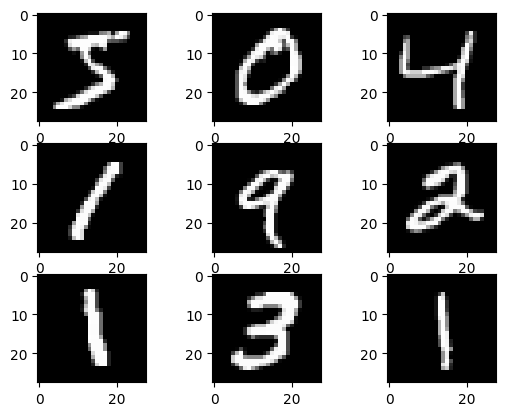

In [2]:
import matplotlib.pyplot as plt
import numpy as np
(x_train, y_train), (x_test, y_test) = tensorflow.keras.datasets.mnist.load_data()
x_train = np.expand_dims(x_train, -1)
x_test = np.expand_dims(x_test, -1)

for i in range(9):
    plt.subplot(3, 3, i+1)
    plt.imshow(x_train[i], cmap="gray")

plt.show()

In [15]:
from typing import Sequence
import flax.linen as nn


class CNN(nn.Module):
    features = Sequence[int]

    @nn.compact
    def __call__(self, x, num_features):
        x = nn.Conv(features=32, kernel_size=(3,3), strides=(2,2))(x)
        x = nn.relu(x)
        x = nn.max_pool(x, window_shape=(2,2))
        # x = x.reshape((x.shape[0], -1))  # flatten
        x = nn.Conv(features=128, kernel_size=(3,3), strides=(2,2))(x)
        x = nn.avg_pool(x, window_shape=(2,2))
        x = nn.Dropout(0.2, deterministic=True)(x)
        x = x.reshape((x.shape[0], -1))  # flatten
        x = nn.Dense(128)(x)

        x = nn.relu(x)
        x = nn.Dense(num_features)(x)
        x = nn.log_softmax(x)
        return x

In [56]:
model = CNN()

number_of_train_samples = x_train.shape[0]

batch_size = 128
number_of_batches, extra = divmod(number_of_train_samples, batch_size)
number_of_iterations = number_of_batches
variables = model.init(random.PRNGKey(0), jnp.ones([1, 28, 28, 1]), 10)


In [57]:
type(variables)
variables["params"].keys()

dict_keys(['Conv_0', 'Conv_1', 'Dense_0', 'Dense_1'])

In [58]:
def loss(params, x, y):
    logits = model.apply({"params": params}, x, num_features=10)
    loss =  -jnp.mean(jnp.sum(nn.log_softmax(logits) * jax.nn.one_hot(y, 10), axis=-1))
    return loss

In [59]:
# logits = model.apply({"params": variables["params"]}, x_train[0], num_features=10)
# print(logits)
untrained_accuracy = loss(variables["params"], jnp.array(x_test), jnp.array(y_test))
untrained_accuracy

Array(61.576347, dtype=float32)

In [60]:
def predict(params, x):
    return jnp.argmax(model.apply({'params': params}, x, 10), axis=-1)

# Predict on first few test images
untrained_predictions = predict(variables["params"], jnp.array(x_test[:9]))
print("Untrained model predictions:", untrained_predictions)

Untrained model predictions: [1 3 3 1 6 3 6 2 6]


In [81]:
# Assuming your loss function is already defined

def train_step(params: dict, x: jnp.ndarray, y: jnp.ndarray, lr: float = 1e-4) -> dict:
    # Compute gradients
    grads = grad(loss)(params, x, y)
    
    # # Debug prints for types
    # print("Type of params:", type(params))  # Should be a dict
    # print("Type of grads:", type(grads))  # Should be a dict similar to params
    # for layer in params:
        # print(f"Type of params[{layer}]:", type(params[layer]))
        # print(f"Type of grads[{layer}]:", type(grads[layer]))
    # Update parameters
    updated_params = {}
    for layer in params:
        updated_layer = {}
        for param in params[layer]:
            # print(f"Type of params[{layer}][{param}]:", type(params[layer][param]))
            # print(f"Type of grads[{layer}][{param}]:", type(grads[layer][param]))
            updated_layer[param] = params[layer][param] - lr * grads[layer][param]
        updated_params[layer] = updated_layer
    
    return updated_params

In [82]:
# params = variables["params"]
for epoch in range(10):
    random_perm = np.random.permutation(x_train.shape[0])
    for i in range(0, number_of_iterations):
        idxs = random_perm[i*batch_size: (i+1) * batch_size]
        # print(idxs)
        # print(idxs)
        # print(x_train[idxs].shape)
        params = train_step(params, x_train[idxs], y_train[idxs])
        current_loss = loss(params, x_train[idxs], y_train[idxs])
        jax.debug.print("Epoch: {}, Batch: {}, Loss: {}", epoch, i, current_loss)
        # print(x_train[idxs].shape)

Epoch: 0, Batch: 0, Loss: 0.4874567985534668
Epoch: 0, Batch: 1, Loss: 0.4586877226829529
Epoch: 0, Batch: 2, Loss: 0.6515821218490601
Epoch: 0, Batch: 3, Loss: 0.4736673831939697
Epoch: 0, Batch: 4, Loss: 0.5322296619415283
Epoch: 0, Batch: 5, Loss: 0.34456968307495117
Epoch: 0, Batch: 6, Loss: 0.6651368141174316
Epoch: 0, Batch: 7, Loss: 0.504629909992218
Epoch: 0, Batch: 8, Loss: 0.4719313383102417
Epoch: 0, Batch: 9, Loss: 0.4522278606891632
Epoch: 0, Batch: 10, Loss: 0.6014803647994995
Epoch: 0, Batch: 11, Loss: 0.6190075278282166
Epoch: 0, Batch: 12, Loss: 0.5695731043815613
Epoch: 0, Batch: 13, Loss: 0.5421462655067444
Epoch: 0, Batch: 14, Loss: 0.5564326643943787
Epoch: 0, Batch: 15, Loss: 0.4878612458705902
Epoch: 0, Batch: 16, Loss: 0.6377912759780884
Epoch: 0, Batch: 17, Loss: 0.39376533031463623
Epoch: 0, Batch: 18, Loss: 0.38760364055633545
Epoch: 0, Batch: 19, Loss: 0.5064979791641235
Epoch: 0, Batch: 20, Loss: 0.7101674675941467
Epoch: 0, Batch: 21, Loss: 0.4420700967311

KeyboardInterrupt: 

In [68]:
import jax 
def dlfn(params, x, y ):
    return grad(loss)(params, x, y)

print(x_train[0].shape)

z=jax.xla_computation(dlfn)(params, np.expand_dims(x_train[0],0), y_train[0])
with open("t.txt", "w") as f:
    f.write(z.as_hlo_text())

(28, 28, 1)


/tmp/ipykernel_1751/4090668910.py:7: DeprecationWarning: jax.xla_computation is deprecated. Please use the AOT APIs; see https://jax.readthedocs.io/en/latest/aot.html. For example, replace xla_computation(f)(*xs) with jit(f).lower(*xs).compiler_ir('hlo'). See CHANGELOG.md for 0.4.30 for more examples.
  z=jax.xla_computation(dlfn)(params, np.expand_dims(x_train[0],0), y_train[0])


In [72]:
with open("t.dot", "w") as f:
    f.write(z.as_hlo_dot_graph())
! dot t.dot  -Tpng > t.png